# Chapter 2: [Discrete Bayes Filter](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/02-Discrete-Bayes.ipynb)

In [3]:
import book_format

book_format.set_style()

## 2.1 Tracking a Dog

追踪一只狗"Simon"，西蒙身上有一个传感器，会读到door，hall等信息。假设走廊只有10个位置，编号0-9：[0: 9]。

首先没有理由相信西蒙在走廊的任何一个特定位置，共有10个位置，那么任意给定位置的概率都为 $\frac{1}{10}$，用数组（numpy）来表示对他位置的信念（belief）。

In [4]:
import numpy as np

belief = np.array([1 / 10] * 10)  # belief of positions
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


在贝叶斯统计（Bayesian statistics）中这称为先验（prior），是合并测量或其他信息前的概率，更完整地说是称为先验概率分布。

现在创建一个走廊，1表示门，0表示墙壁。

In [5]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

为每扇门分配一个概率。所有门的可能性均等，并且共有3扇门，因此为每扇门分配 $\frac{1}{3}$ 的概率

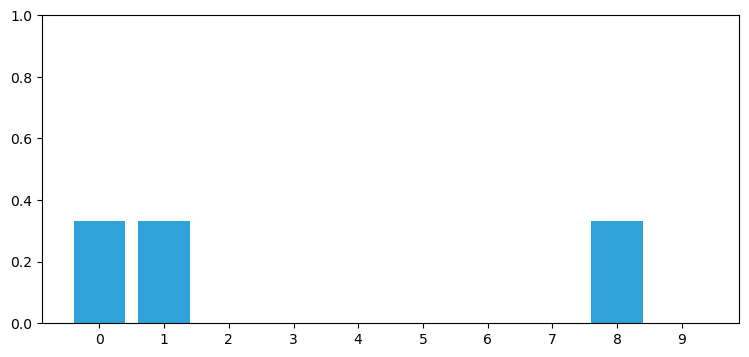

In [6]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt

belief = np.array([1 / 3, 1 / 3, 0, 0, 0, 0, 0, 0, 1 / 3, 0])
book_plots.bar_plot(belief)

这种分布称为分类分布（categorical distribution），描述n个结果的离散分布。这是一个多峰分布，因为我们对于狗的位置有多种信念。我的（贝叶斯）信念是，在0号门的概率是33.3% ……

In [7]:
belief = hallway * (1 / 3)
print(belief)

[0.333 0.333 0.    0.    0.    0.    0.    0.    0.333 0.   ]


## 2.2 Extracting Information from Sensor Readings

假设从传感器中读出以下：door, move right, door。我们可以肯定他在第2扇门，我们的信念是：

In [8]:
belief = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

## 2.3 Noisy Sensors  噪声传感器

为每扇门分配一个小于1/3的概率，为墙分配一个小概率。

考虑传感器噪声引起的额外的不确定性，假设读取了门的读数，假设测试表明传感器正确的可能性是错误的3倍。如果有门，应该将概率分布缩放3，如果我们这样做，结果将不再是概率分布

belief: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum = 1.6000000000000003


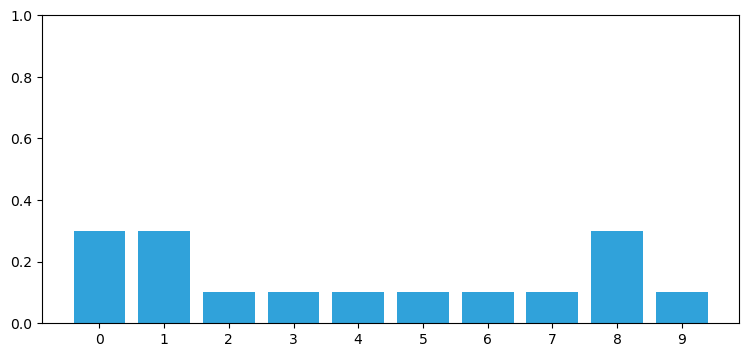

In [10]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale


belief = np.array([0.1] * 10)
reading = 1
update_belief(hallway, belief, reading, correct_scale=3)
print('belief:', belief)
print('sum =', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

In [14]:
# 归一化
print(belief / sum(belief))

from filterpy.discrete_bayes import normalize

print(normalize(belief))

[0.188 0.188 0.062 0.062 0.062 0.062 0.062 0.062 0.188 0.062]
[0.188 0.188 0.062 0.062 0.062 0.062 0.062 0.062 0.188 0.062]


指定传感器正确的概率，并据此计算比例因子 scale
$$
    scale = \frac{prob_{correct}}{prob_{incorrect}} = \frac{prob_{correct}}{1 - prob_{correct}}
$$

使用bool方式找到所有门

In [16]:
print(hallway == 1)

[ True  True False False False False False False  True False]


sum = 1.0
prob of door = 0.1875
prob of wall = 0.06249999999999999


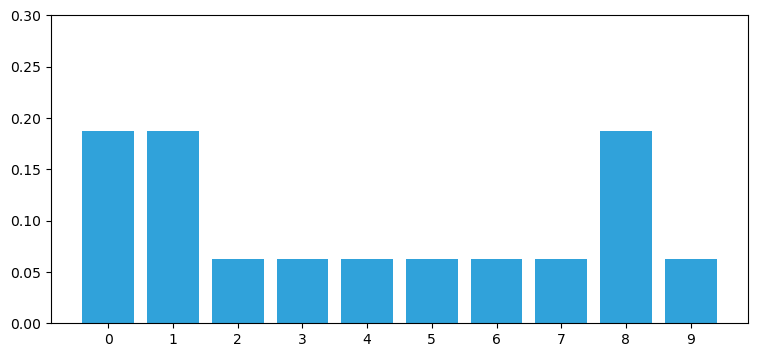

In [18]:
from filterpy.discrete_bayes import normalize


def scaled_update(hall, belief, z, z_prob):
    scale = z_prob / (1 - z_prob)
    belief[hall == z] *= scale
    normalize(belief)


belief = np.array([0.1] * 10)
scaled_update(hallway, belief, z=1, z_prob=0.75)
print('sum =', sum(belief))
print('prob of door =', belief[0])
print('prob of wall =', belief[2])
book_plots.bar_plot(belief, ylim=(0, .3))

从输出中我们可以看到，总和现在为 1.0，并且门与墙的概率仍然大三倍。结果也符合我们的直觉，即门的概率必须小于 0.333，墙的概率必须大于 0.0。最后，它应该符合我们的直觉，即我们尚未获得任何信息来区分任何给定的门或墙壁位置，因此所有门位置应具有相同的值，墙壁位置也应如此。

这个结果称为后验（posterior），是合并测量信息后的概率分布

当我们谈论滤波器的输出时，我们通常将执行预测后的状态称为先验状态或预测状态，将更新后的状态称为后验状态或估计状态。

In [20]:
def scaled_update(hall, belief, z, z_prob):
    scale = z_prob / (1 - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall == z] *= scale
    return normalize(likelihood * belief)


# 从函数中删除似然性的计算，并要求调用者自己计算似然性。
def update(likelihood, belief):
    return normalize(likelihood * belief)


# filterpy实现更新，是前面示例的完全通用形式：
from filterpy.discrete_bayes import update


def lh_hallway(hall, z, z_prob):
    """
    compute likelihood that a measurement matches positions in the hillway
    """
    try:
        scale = z_prob / (1 - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall == z] *= scale
    return likelihood


belief = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=0.75)
print(update(likelihood, belief))

[0.188 0.188 0.062 0.062 0.062 0.062 0.062 0.062 0.188 0.062]


## 2.4 Incorporating Movement

整合一系列测量和运动更新时，我们能够多么快地找到精确的解决方案

首先让我们处理一个简单的情况 - 假设运动传感器是完美的，并且它报告狗已向右移动一格。我们将如何改变我们的信念阵列？我希望经过片刻的思考，我们应该将所有值向右移动一格。

如果我们之前认为西蒙有 50% 的机会位于位置 3，那么当他向右移动一个位置后，我们应该相信他有 50% 的机会位于位置 4。走廊是圆形的，所以我们将使用模运算来执行移位。

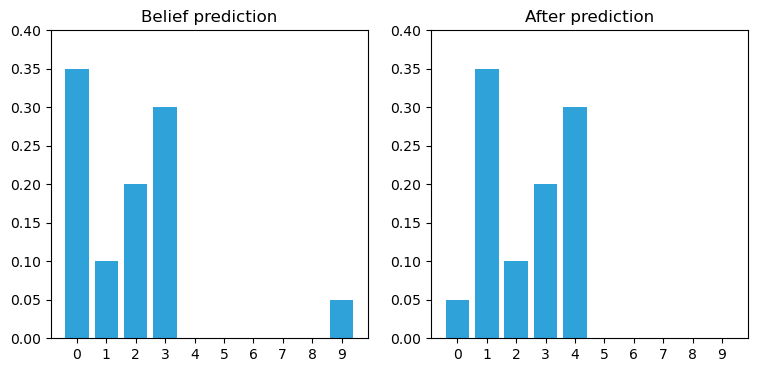

In [23]:
def perfect_predict(belief, move):
    """
    移动
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i - move) % n]
    return result


belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
plt.subplot(121)
book_plots.bar_plot(belief, title="Before prediction", ylim=(0, 0.4))

belief = perfect_predict(belief, 1)  # 右移1位
plt.subplot(122)
book_plots.bar_plot(belief, title="After prediction", ylim=(0, 0.4))

## 2.6 Adding Uncertainty to the Prediction

假设传感器的运动测量正确的可能性为 80%，向右超出一个位置的可能性为 10%，向左下冲的可能性为 10%。也就是说，如果移动测量值为 4（意味着向右移动 4 个空格），则狗有 80% 可能向右移动 4 个空格，10% 可能向右移动 3 个空格，10% 可能向右移动 5 个空格。数组中的每个结果现在都需要包含 3 种不同情况的概率。例如，考虑报告的运动 2。如果我们 100% 确定狗从位置 3 开始，那么它有 80% 的机会位于 5，并且有 10% 的机会位于 4 或 6。让我们尝试编码:

[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]


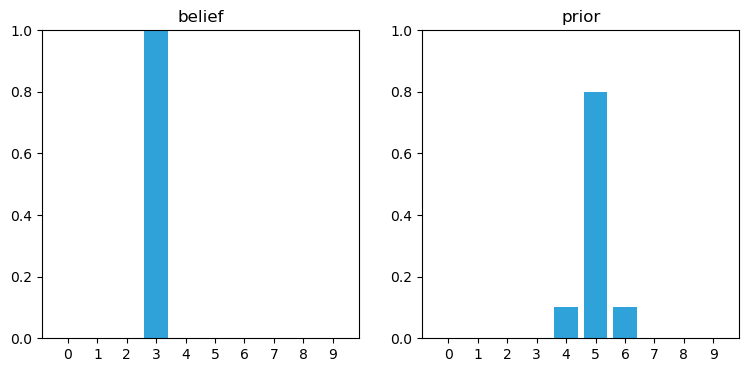

In [27]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
                belief[(i - move) % n] * p_correct +
                belief[(i - move - 1) % n] * p_over +
                belief[(i - move + 1) % n] * p_under
        )
    return prior


belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, 0.1, 0.8, 0.1)
print(prior)
book_plots.plot_belief_vs_prior(belief, prior)

[0.   0.   0.   0.04 0.38 0.52 0.06 0.   0.   0.  ]


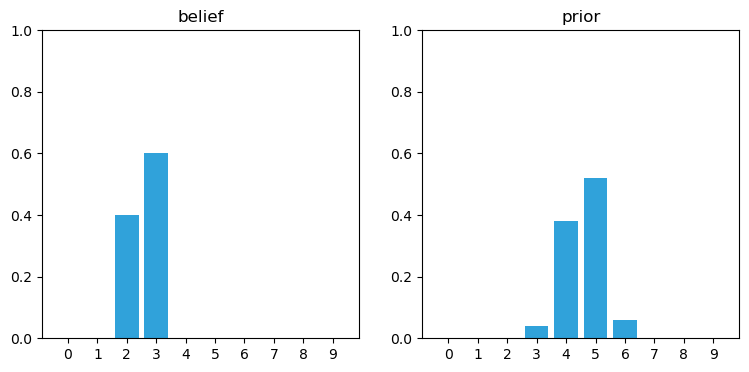

In [28]:
# 当 belief 不是 100% 时
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)
print(prior)

## 2.7 Generalizing with Convolution

In [29]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1) / 2)
    prior = np.zeros(N)
    for i in range(N):
        for k in range(kN):
            index = (i + (width - k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

# convolve(np.roll(pdf, offset), kernel, mode='wrap')

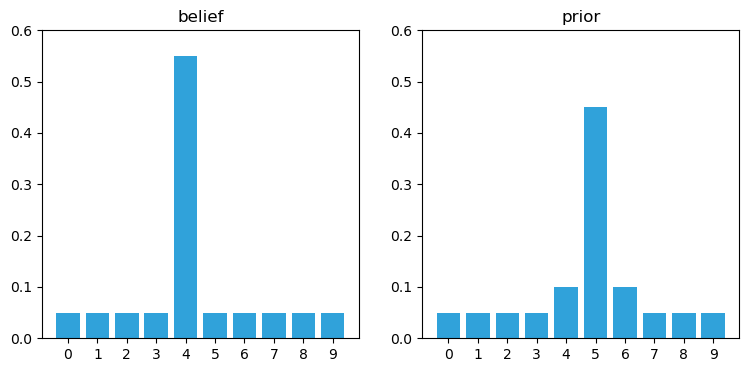

In [30]:
from filterpy.discrete_bayes import predict

belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
prior = predict(belief, offset=1, kernel=[.1, .8, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0, 0.6))

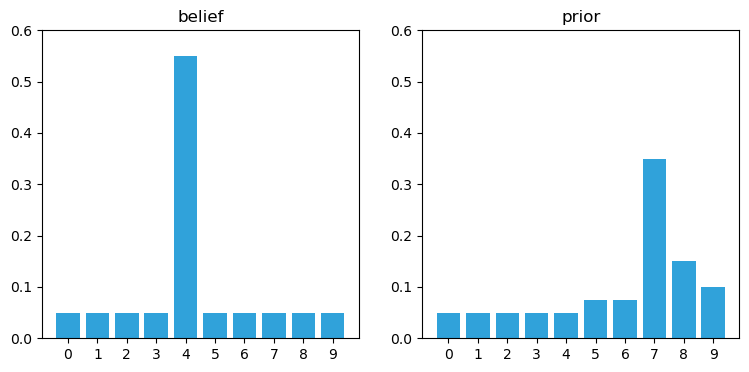

In [31]:
prior = predict(belief, offset=3, kernel=[.05, .05, .6, .2, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0, 0.6))

## 2.8 Integrating Measurements and Movement Updates

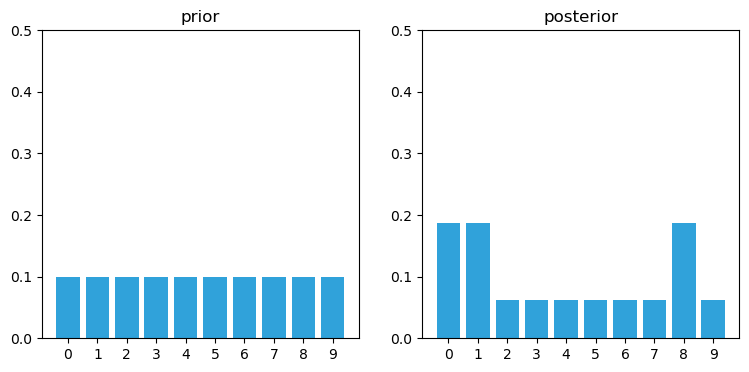

In [32]:
from filterpy.discrete_bayes import update

hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0, .5))

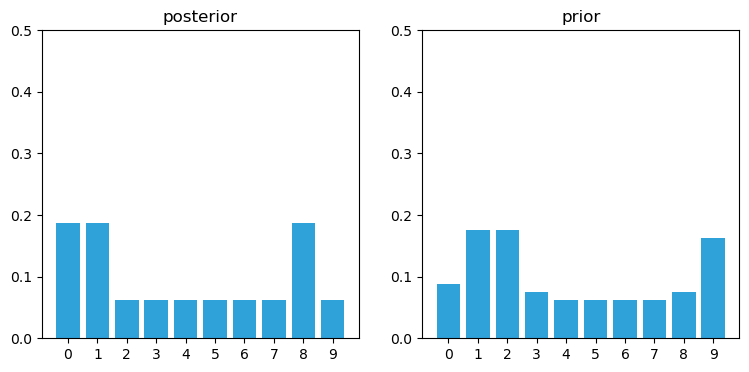

In [34]:
kernel = (.1, .8, .1)
prior = predict(posterior, 1, kernel)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim=(0, .5))

# 预测步骤将这些概率向右移动，稍微模糊了它们。

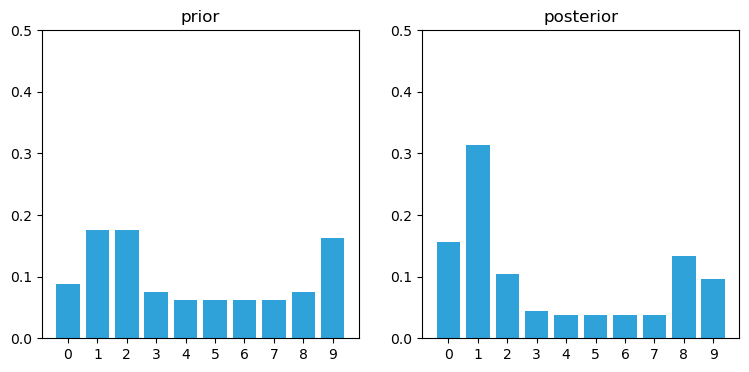

In [35]:
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0, .5))

请注意位置 1 处的高条。这对应于从位置 0 开始、感测到一扇门、将 1 向右移动并感测到另一扇门的（正确）情况。没有其他立场使这组观察结果更有可能发生。现在我们将添加更新，然后感知墙壁。

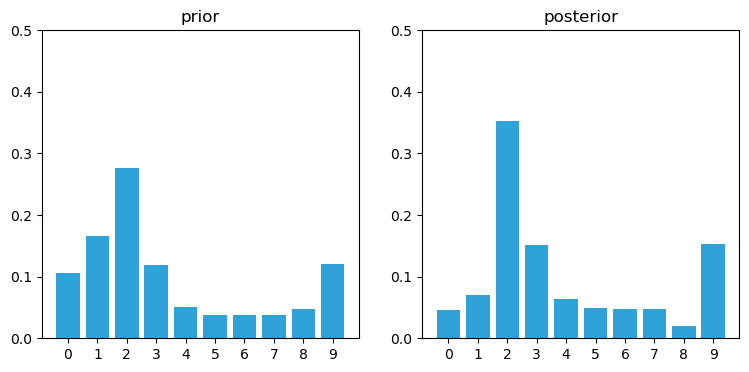

In [36]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0, .5))

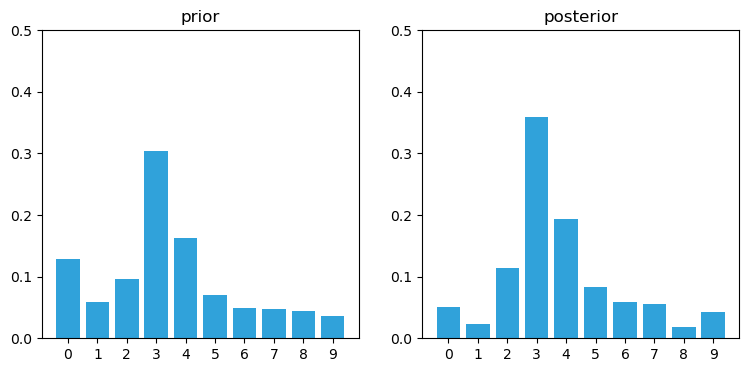

In [37]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0, .5))